In [30]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torch.utils.data.dataset import Dataset
from PIL import Image
import torchvision
from torchvision.utils import make_grid
import os
from tqdm import tqdm
import glob
import pickle
from matplotlib import pyplot as plt
import numpy as np
from torch.optim import Adam
import cv2
import random
from skimage.metrics import structural_similarity as ssim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Create Dataset to hold input and conditional image pair

In [31]:
class ConditionalDataset(Dataset):
    def __init__(self, img_path, img_ext="mpy"):
        self.img_ext = img_ext  # Correct variable name for consistency
        self.image_files = [os.path.join(img_path, f) for f in os.listdir(img_path)]
        self.images = []
        self.inputs = []
        self.conditionals = []
        
        for file in self.image_files:
            filepath = os.path.join(img_path, file)
             # Load image on demand
            with open(filepath, 'rb') as f:
                img_arr = pickle.load(f)  # Assume images are stored as pickled numpy arrays
            
            self.images = img_arr
    
            for idx in range(4, len(self.images)):
                self.inputs.append(self.images[idx])
                self.conditionals.append(self.images[idx - 4])
    
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, index):
        img = self.inputs[index]
        conditional = self.conditionals[index]
        
        # Convert numpy array to tensor
        img_tensor = torchvision.transforms.ToTensor()(img)
        cond_tensor = torchvision.transforms.ToTensor()(conditional)
        
        # Normalize the tensor
        img_tensor = (2 * img_tensor) - 1
        cond_tensor = (2 * cond_tensor) - 1
        return img_tensor, cond_tensor

In [32]:
DATA_DIR = "C:/Users/Anirbit/Desktop/MSc/Ind Project/Msc-Project/data"

BATCH_SIZE = 64

# create dataset
train_ratio = 0.8
test_ratio = 1 - train_ratio

data = ConditionalDataset(os.path.join(DATA_DIR, "bin_frames"))

train_size = int(train_ratio * (len(data)))
test_size = (len(data)) - train_size

train_data, test_data = random_split(data, [train_size, test_size])

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

0


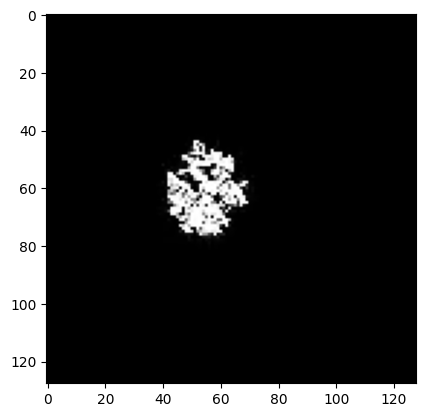

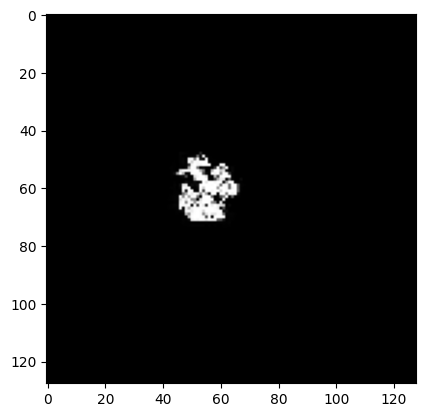

In [33]:
for idx, (x, y) in enumerate(train_loader):
    print(idx)
    plt.imshow(x[0].permute(1, 2, 0), cmap='gray')
    plt.show()
    plt.imshow(y[0].permute(1, 2, 0), cmap='gray')
    plt.show()
    break

### Conditional Denoising Diffusion Model 

#### Noise Scheduler


In [34]:
class LinearNoiseScheduler:
    def __init__(self, num_timesteps, beta_start, beta_end, device):
        self.num_timesteps = num_timesteps
        self.beta_start = beta_start
        self.beta_end = beta_end
        
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps)
        self.alphas = 1. - self.betas
        self.alpha_cum_prod = torch.cumprod(self.alphas, dim=0).to(device)
        self.sqrt_alpha_cum_prod = torch.sqrt(self.alpha_cum_prod).to(device)
        self.sqrt_one_minus_alpha_cum_prod = torch.sqrt(1. - self.alpha_cum_prod).to(device)
        
    def add_noise(self, original, noise, t):
        original_shape = original.shape
        batch_size = original_shape[0]
        
        sqrt_alpha_cum_prod = self.sqrt_alpha_cum_prod[t].reshape(batch_size)
        sqrt_one_minus_alpha_cum_prod = self.sqrt_one_minus_alpha_cum_prod[t].reshape(batch_size)
        
        for _ in range(len(original_shape) - 1):
            sqrt_alpha_cum_prod = sqrt_alpha_cum_prod.unsqueeze(-1)
            sqrt_one_minus_alpha_cum_prod = sqrt_one_minus_alpha_cum_prod.unsqueeze(-1)
        
        return sqrt_alpha_cum_prod  * original  + sqrt_one_minus_alpha_cum_prod * noise
    
    
    def sample_prev_timestep(self, xt, noise_pred, t):
        """
            Use the noise prediction by model to get
            xt-1 using xt and the noise predicted
        :param xt: current timestep sample
        :param noise_pred: model noise prediction
        :param t: current timestep we are at
        :return:
        """
        x0 = ((xt - (self.sqrt_one_minus_alpha_cum_prod.to(xt.device)[t] * noise_pred)) /
              torch.sqrt(self.alpha_cum_prod.to(xt.device)[t]))
        x0 = torch.clamp(x0, -1., 1.)
        
        mean = xt - ((self.betas.to(xt.device)[t]) * noise_pred) / (self.sqrt_one_minus_alpha_cum_prod.to(xt.device)[t])
        mean = mean / torch.sqrt(self.alphas.to(xt.device)[t])
        
        if t == 0:
            return mean, x0
        else:
            variance = (1 - self.alpha_cum_prod.to(xt.device)[t - 1]) / (1.0 - self.alpha_cum_prod.to(xt.device)[t])
            variance = variance * self.betas.to(xt.device)[t]
            sigma = variance ** 0.5
            z = torch.randn(xt.shape).to(xt.device)
            
            # OR
            # variance = self.betas[t]
            # sigma = variance ** 0.5
            # z = torch.randn(xt.shape).to(xt.device)
            return mean + sigma * z, x0

#### Model component blocks

In [35]:
def get_time_embedding(time_steps, t_emb_dim):
    factor = 10000 ** ((torch.arange(
        start=0, end=t_emb_dim//2, device=time_steps.device) / (t_emb_dim // 2)
    ))
    t_emb = time_steps[:, None].repeat(1, t_emb_dim // 2) / factor
    t_emb = torch.cat([torch.sin(t_emb), torch.cos(t_emb)], dim=-1)
    return t_emb

class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, t_emb_dim,
                 down_sample=True, num_heads=4, num_layers=1):
        super().__init__()
        self.num_layers = num_layers
        self.down_sample = down_sample
        self.resnet_conv_first = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(8, in_channels if i == 0 else out_channels),
                    nn.SiLU(),
                    nn.Conv2d(in_channels if i == 0 else out_channels, out_channels,
                              kernel_size=3, stride=1, padding=1),
                )
                for i in range(num_layers)
            ]
        )
        self.t_emb_layers = nn.ModuleList([
            nn.Sequential(
                nn.SiLU(),
                nn.Linear(t_emb_dim, out_channels)
            )
            for _ in range(num_layers)
        ])
        self.resnet_conv_second = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(8, out_channels),
                    nn.SiLU(),
                    nn.Conv2d(out_channels, out_channels,
                              kernel_size=3, stride=1, padding=1),
                )
                for _ in range(num_layers)
            ]
        )
        self.attention_norms = nn.ModuleList(
            [nn.GroupNorm(8, out_channels)
             for _ in range(num_layers)]
        )
        
        self.attentions = nn.ModuleList(
            [nn.MultiheadAttention(out_channels, num_heads, batch_first=True)
             for _ in range(num_layers)]
        )
        self.residual_input_conv = nn.ModuleList(
            [
                nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=1)
                for i in range(num_layers)
            ]
        )
        self.down_sample_conv = nn.Conv2d(out_channels, out_channels,
                                          4, 2, 1) if self.down_sample else nn.Identity()
        
    def forward(self, x, t_emb):
        out = x
        for i in range(self.num_layers):
            
            # Resnet block of Unet
            resnet_input = out
            out = self.resnet_conv_first[i](out)
            out = out + self.t_emb_layers[i](t_emb)[:, :, None, None]
            out = self.resnet_conv_second[i](out)
            out = out + self.residual_input_conv[i](resnet_input)
            
            # Attention block of Unet
            # batch_size, channels, h, w = out.shape
            # in_attn = out.reshape(batch_size, channels, h * w)
            # in_attn = self.attention_norms[i](in_attn)
            # in_attn = in_attn.transpose(1, 2)
            # out_attn, _ = self.attentions[i](in_attn, in_attn, in_attn)
            # out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
            # out = out + out_attn
            
        out = self.down_sample_conv(out)
        return out
    
class MidBlock(nn.Module):
    def __init__(self, in_channels, out_channels, t_emb_dim, num_heads=4, num_layers=1):
        super().__init__()
        self.num_layers = num_layers
        self.resnet_conv_first = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(8, in_channels if i == 0 else out_channels),
                    nn.SiLU(),
                    nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=3, stride=1,
                              padding=1),
                )
                for i in range(num_layers+1)
            ]
        )
        self.t_emb_layers = nn.ModuleList([
            nn.Sequential(
                nn.SiLU(),
                nn.Linear(t_emb_dim, out_channels)
            )
            for _ in range(num_layers + 1)
        ])
        self.resnet_conv_second = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(8, out_channels),
                    nn.SiLU(),
                    nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                )
                for _ in range(num_layers+1)
            ]
        )
        
        self.attention_norms = nn.ModuleList(
            [nn.GroupNorm(8, out_channels)
                for _ in range(num_layers)]
        )
        
        self.attentions = nn.ModuleList(
            [nn.MultiheadAttention(out_channels, num_heads, batch_first=True)
                for _ in range(num_layers)]
        )
        self.residual_input_conv = nn.ModuleList(
            [
                nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=1)
                for i in range(num_layers+1)
            ]
        )
    
    def forward(self, x, t_emb):
        out = x
        
        # First resnet block
        resnet_input = out
        out = self.resnet_conv_first[0](out)
        out = out + self.t_emb_layers[0](t_emb)[:, :, None, None]
        out = self.resnet_conv_second[0](out)
        out = out + self.residual_input_conv[0](resnet_input)
        
        for i in range(self.num_layers):
            
            # Attention Block
            # batch_size, channels, h, w = out.shape
            # in_attn = out.reshape(batch_size, channels, h * w)
            # in_attn = self.attention_norms[i](in_attn)
            # in_attn = in_attn.transpose(1, 2)
            # out_attn, _ = self.attentions[i](in_attn, in_attn, in_attn)
            # out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
            # out = out + out_attn
            
            # Resnet Block
            resnet_input = out
            out = self.resnet_conv_first[i+1](out)
            out = out + self.t_emb_layers[i+1](t_emb)[:, :, None, None]
            out = self.resnet_conv_second[i+1](out)
            out = out + self.residual_input_conv[i+1](resnet_input)
        
        return out
    
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, t_emb_dim, up_sample=True, num_heads=4, num_layers=1):
        super().__init__()
        self.num_layers = num_layers
        self.up_sample = up_sample
        self.resnet_conv_first = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(8, in_channels if i == 0 else out_channels),
                    nn.SiLU(),
                    nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=3, stride=1,
                              padding=1),
                )
                for i in range(num_layers)
            ]
        )
        self.t_emb_layers = nn.ModuleList([
            nn.Sequential(
                nn.SiLU(),
                nn.Linear(t_emb_dim, out_channels)
            )
            for _ in range(num_layers)
        ])
        self.resnet_conv_second = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(8, out_channels),
                    nn.SiLU(),
                    nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                )
                for _ in range(num_layers)
            ]
        )
        
        self.attention_norms = nn.ModuleList(
            [
                nn.GroupNorm(8, out_channels)
                for _ in range(num_layers)
            ]
        )
        
        self.attentions = nn.ModuleList(
            [
                nn.MultiheadAttention(out_channels, num_heads, batch_first=True)
                for _ in range(num_layers)
            ]
        )
        self.residual_input_conv = nn.ModuleList(
            [
                nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=1)
                for i in range(num_layers)
            ]
        )
        self.up_sample_conv = nn.ConvTranspose2d(in_channels // 2, in_channels // 2,
                                                 4, 2, 1) \
            if self.up_sample else nn.Identity()
        
    def forward(self, x, out_down, t_emb):
        x = self.up_sample_conv(x)
        x = torch.cat([x, out_down], dim=1)
        
        out = x
        for i in range(self.num_layers):
            resnet_input = out
            out = self.resnet_conv_first[i](out)
            out = out + self.t_emb_layers[i](t_emb)[:, :, None, None]
            out = self.resnet_conv_second[i](out)
            out = out + self.residual_input_conv[i](resnet_input)
            
            # batch_size, channels, h, w = out.shape
            # in_attn = out.reshape(batch_size, channels, h * w)
            # in_attn = self.attention_norms[i](in_attn)
            # in_attn = in_attn.transpose(1, 2)
            # out_attn, _ = self.attentions[i](in_attn, in_attn, in_attn)
            # out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
            # out = out + out_attn

        return out

#### Conditional Unet

In [36]:
class Unet(nn.Module):
    def __init__(self, model_config):
        super().__init__()
        im_channels = model_config['in_channels']
        self.down_channels = model_config['down_channels']
        self.mid_channels = model_config['mid_channels']
        self.t_emb_dim = model_config['time_emb_dim']
        self.down_sample = model_config['down_sample']
        self.num_down_layers = model_config['num_down_layers']
        self.num_mid_layers = model_config['num_mid_layers']
        self.num_up_layers = model_config['num_up_layers']
        
        assert self.mid_channels[0] == self.down_channels[-1]
        assert self.mid_channels[-1] == self.down_channels[-2]
        assert len(self.down_sample) == len(self.down_channels) - 1
        
        # Initial projection from sinusoidal time embedding
        self.t_proj = nn.Sequential(
            nn.Linear(self.t_emb_dim, self.t_emb_dim),
            nn.SiLU(),
            nn.Linear(self.t_emb_dim, self.t_emb_dim)
        )

        self.up_sample = list(reversed(self.down_sample))
        self.conv_in = nn.Conv2d(im_channels*2, self.down_channels[0], kernel_size=3, padding=(1, 1))
        
        self.downs = nn.ModuleList([])
        for i in range(len(self.down_channels)-1):
            self.downs.append(DownBlock(self.down_channels[i], self.down_channels[i+1], self.t_emb_dim,
                                        down_sample=self.down_sample[i], num_layers=self.num_down_layers))
        
        self.mids = nn.ModuleList([])
        for i in range(len(self.mid_channels)-1):
            self.mids.append(MidBlock(self.mid_channels[i], self.mid_channels[i+1], self.t_emb_dim,
                                      num_layers=self.num_mid_layers))
        
        self.ups = nn.ModuleList([])
        for i in reversed(range(len(self.down_channels)-1)):
            self.ups.append(UpBlock(self.down_channels[i] * 2, self.down_channels[i-1] if i != 0 else 16,
                                    self.t_emb_dim, up_sample=self.down_sample[i], num_layers=self.num_up_layers))
        
        self.norm_out = nn.GroupNorm(8, 16)
        self.conv_out = nn.Conv2d(16, im_channels, kernel_size=3, padding=1)
        
    def forward(self, x, cond, t):
        x = torch.cat([x, cond], dim=1)  # Concatenate input and conditional image
        out = self.conv_in(x)
        t_emb = get_time_embedding(t, self.t_emb_dim)
        t_emb = self.t_proj(t_emb)
        
        down_outs = []
        for idx, down in enumerate(self.downs):
            down_outs.append(out)
            out = down(out, t_emb)
        
        for mid in self.mids:
            out = mid(out, t_emb)
            
        for up in self.ups:
            down_out = down_outs.pop()
            out = up(out, down_out, t_emb)
        
        out = self.norm_out(out)
        out = nn.SiLU()(out)
        out = self.conv_out(out)
        return out

#### Training conditional diffusion

In [51]:
DATA_DIR = "C:/Users/Anirbit/Desktop/MSc/Ind Project/Msc-Project/data"
RESULT_DIR = "C:/Users/Anirbit/Desktop/MSc/Ind Project/Msc-Project/results"
CKPT_DIR = "C:/Users/Anirbit/Desktop/MSc/Ind Project/Msc-Project/results/ckpts"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

diffusion_config = {
    "num_timesteps" : 1000,
    "beta_start" : 0.0001,
    "beta_end" : 0.02
}

model_config = {
    "in_channels" : 1,
    "im_size" : 128,
    "down_channels" : [32, 64, 128, 256],
    "mid_channels" : [256, 256, 128],
    "down_sample" : [True, True, False],
    "time_emb_dim" : 128,
    "num_down_layers" : 1,
    "num_mid_layers" : 1,
    "num_up_layers" : 1,
    "num_heads" : 1,
}

train_config = {
    "task_name" : 'conditional_ddpm_adv',
    "batch_size" : 64,
    "num_epochs" : 40,
    "num_samples" : 100,
    "num_grid_rows" : 10,
    "lr" : 0.0001, 
    "ckpt_name" : 'conditional_ddpm_2.pth'
}

def train_conditional_ddpm():
    # create noise scheduler 
    print("Created Noise Scheduler")
    scheduler = LinearNoiseScheduler(num_timesteps=diffusion_config["num_timesteps"],
                                     beta_start=diffusion_config["beta_start"],
                                     beta_end=diffusion_config["beta_end"], 
                                     device=device)
    
    # model
    print("Created Model")
    model = Unet(model_config=model_config).to(device)
    model.train()
    
    # Create output dirs
    if not os.path.exists(os.path.join(RESULT_DIR, train_config["task_name"])):
        os.mkdir(os.path.join(RESULT_DIR, train_config["task_name"]))
    
    # find checkpoint
    if os.path.exists(os.path.join(CKPT_DIR, train_config["ckpt_name"])):
        print("Loading checkpoint found")
        model.load_state_dict(torch.load(os.path.join(CKPT_DIR, train_config["ckpt_name"]), map_location=device))
        
    # Training params
    num_epochs = train_config["num_epochs"]
    optimizer = Adam(model.parameters(), lr=train_config["lr"])
    criterion = torch.nn.MSELoss()
    
    for epoch in range(num_epochs):
        print(f"starting epoch: {epoch}")
        losses = []
        for img_tensor, cond_tensor in train_loader:
            optimizer.zero_grad()
            print("sampling image...")
            img_tensor = img_tensor.float().to(device)
            cond_tensor = cond_tensor.float().to(device)
            
            # sample random noise 
            print("Sampling Noise...")
            noise = torch.randn_like(img_tensor).to(device)
            
            # sample timestep
            print("Sampling Timestep...")
            t = torch.randint(0, diffusion_config["num_timesteps"], (img_tensor.shape[0],)).to(device)
            
            # Add noise to images according to timestep
            print("Adding Noise to Image...")
            noisy_img = scheduler.add_noise(img_tensor, noise, t)
            print("Predicting Noise...")
            noise_pred = model(noisy_img, cond_tensor, t)
            
            print("Calculating Loss in Predicted Noise...")
            loss = criterion(noise_pred, noise)
            losses.append(loss.item())
            print("BackProp...")
            loss.backward()
            optimizer.step()
            
        print(f'Finished epoch: {epoch + 1} | Loss: {np.mean(losses)}')
        torch.save(model.state_dict(), os.path.join(CKPT_DIR, train_config["ckpt_name"]))
        
    print("Done Training...")

In [ ]:
train_conditional_ddpm()

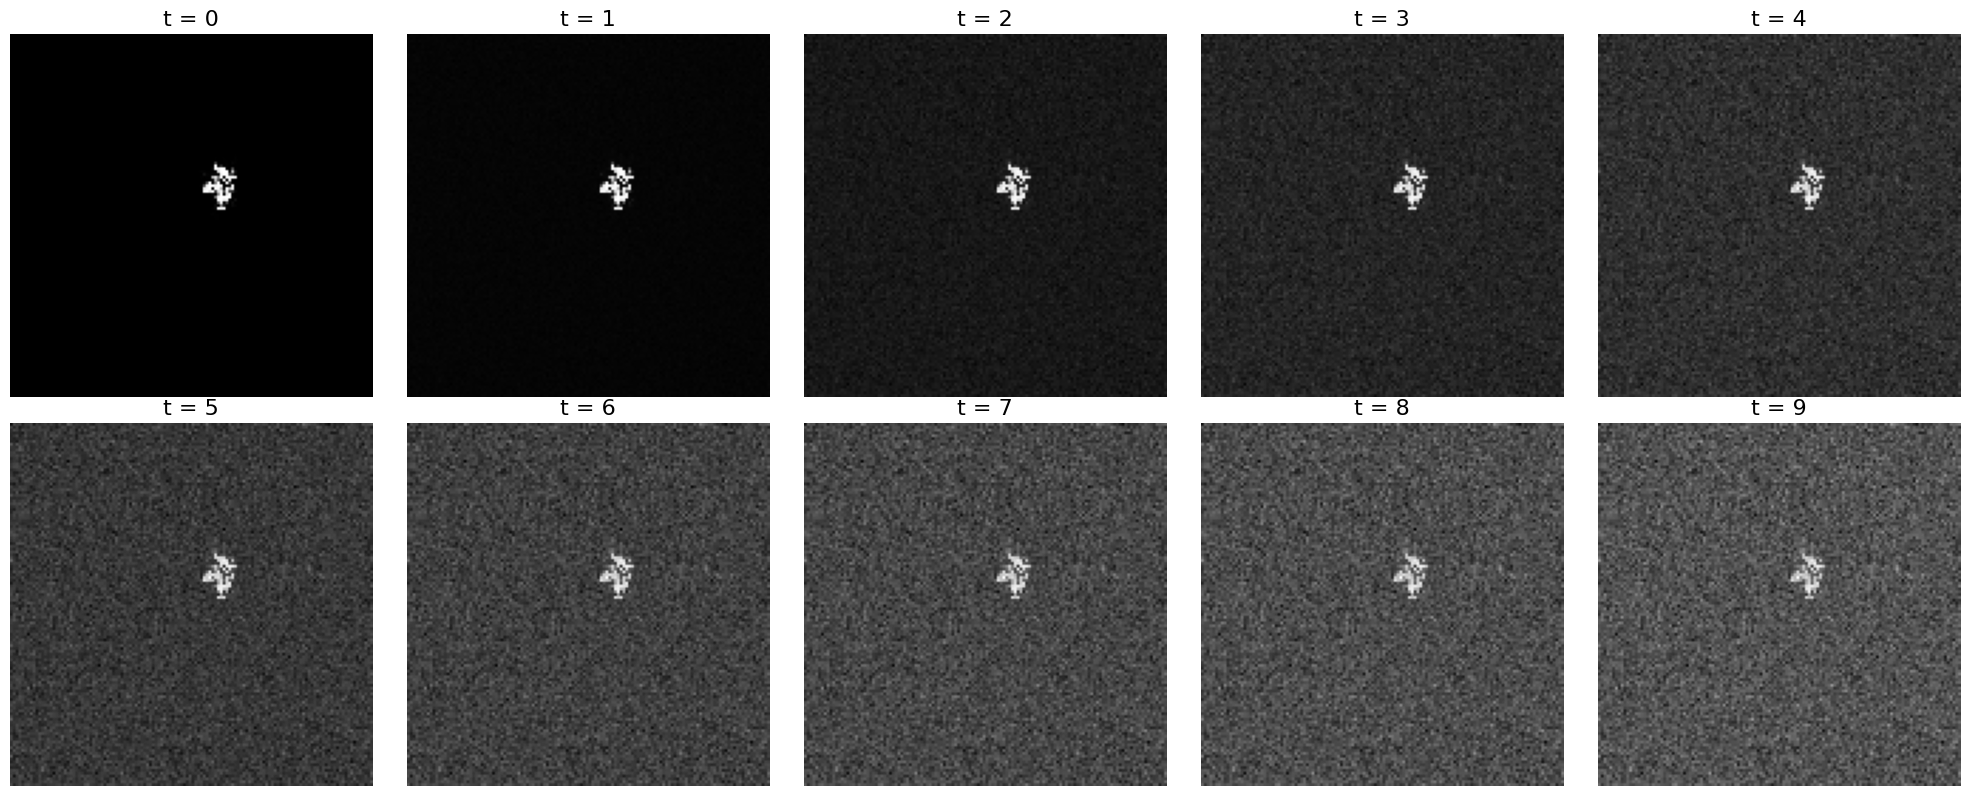

In [23]:
# Initialize parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_timesteps = 9
beta_start = 0.0001
beta_end = 0.02

# Create an instance of the scheduler
scheduler = LinearNoiseScheduler(num_timesteps, beta_start, beta_end, device)

# Load a sample image (for simplicity, use a random tensor as a placeholder)
image_size = (1, 128, 128)  # example for a grayscale image of size 28x28
original_image = next(iter(test_loader))[0][0]
original_image = original_image.to(device)

# Generate noise
noise = torch.randn(image_size).to(device)

# Generate noisy images for each timestep
noisy_images = []
for t in range(num_timesteps):
    noisy_image = scheduler.add_noise(original_image, noise, t)
    noisy_images.append(noisy_image.cpu().numpy().squeeze())

# Generate the non-noisy image for t=0
non_noisy_image = original_image.cpu().numpy().squeeze()

# Plot the non-noisy image and the noisy images
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

axes[0].imshow(non_noisy_image, cmap='gray')
axes[0].axis('off')
axes[0].set_title('t = 0', fontsize=16)

# Plot the noisy images
for idx, img in enumerate(noisy_images):
    axes[idx+1].imshow(img, cmap='gray')
    axes[idx+1].axis('off')
    axes[idx+1].set_title(f't = {idx+1}', fontsize=16)

plt.tight_layout()
plt.show()

#### Test with trained model

In [58]:
MODEL_PATH = "C:/Users/Anirbit/Desktop/MSc/Ind Project/Msc-Project/results/ckpts/conditional_ddpm_1layer.pth"

In [39]:
def save_conditional_grid(cond_tensor, nrows=10):
    cond_tensor = (cond_tensor + 1) / 2
    grid = make_grid(cond_tensor, nrow=nrows)
    
    grid_img = torchvision.transforms.ToPILImage()(grid)
    
    grid_img.save(os.path.join(RESULT_DIR, train_config["task_name"], "cond_grid_1.png"))
    grid_img.close()
    
def sample_n(dataloader, n):
    all_data = []
    
    for img_tensor, cond_tensor in dataloader:
        all_data.append((img_tensor, cond_tensor))
        
    all_data = [(img, cond) for batch in all_data for img, cond in zip(*batch)]
    
    sampled_data = random.sample(all_data, n)
    
    sampled_inputs = torch.stack([item[0] for item in sampled_data])
    sampled_conds = torch.stack([item[1] for item in sampled_data])
    
    return sampled_inputs.float(), sampled_conds.float()

def sample_conditional(model, scheduler, sampled_conds, grid_rows=None, sample_size=None, save_final=False):
    cond_tensor = sampled_conds.to(device)
    
    if sample_size is None:
        sample_size = train_config["num_samples"]
        
    if grid_rows is None:
        grid_rows = train_config["num_grid_rows"]
    
    xt = torch.randn((sample_size, model_config["in_channels"], 128, 128)).to(device).float()
    
    for i in tqdm(reversed(range(diffusion_config["num_timesteps"]))):
        # xt_cond = torch.cat([xt, cond_tensor], dim=1)
        
        noise_pred = model(xt, cond_tensor, torch.as_tensor(i).unsqueeze(0).to(device))
        
        xt, x0_pred = scheduler.sample_prev_timestep(xt, noise_pred, torch.as_tensor(i).to(device))
        
        ims = torch.clamp(xt, -1., 1.).detach().cpu()
        ims = (ims + 1) / 2
        grid = make_grid(ims, nrow=grid_rows)
        img = torchvision.transforms.ToPILImage()(grid)
        
        if save_final and i==0:
            if not os.path.exists(os.path.join(RESULT_DIR, train_config["task_name"], "samples")):
                os.mkdir(os.path.join(RESULT_DIR, train_config["task_name"], "samples"))
            img.save(os.path.join(RESULT_DIR, train_config["task_name"], "samples", "x0_{}.png".format(i)))
            img.close()
            return ims
            
        elif not save_final:
            if not os.path.exists(os.path.join(RESULT_DIR, train_config["task_name"], "samples")):
                os.mkdir(os.path.join(RESULT_DIR, train_config["task_name"], "samples"))
            img.save(os.path.join(RESULT_DIR, train_config["task_name"], "samples", "x0_{}.png".format(i)))
            img.close()
        
def infer_conditional():
    model = Unet(model_config).to(device)
    model.load_state_dict(torch.load(MODEL_PATH))
    
    model.eval()
    
    scheduler = LinearNoiseScheduler(num_timesteps=diffusion_config["num_timesteps"],
                                     beta_start=diffusion_config["beta_start"],
                                     beta_end=diffusion_config["beta_end"],
                                     device=device)
    
    _, conditional_imgs = sample_n(test_loader, train_config["num_samples"])
    save_conditional_grid(conditional_imgs)
    
    with torch.no_grad():
        sample_conditional(model, scheduler, conditional_imgs)    

In [40]:
infer_conditional()

0it [00:00, ?it/s]c:\Users\Anirbit\anaconda3\envs\mscproj\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
1000it [14:02,  1.19it/s]


#### Evaluate model outputs against conditional images

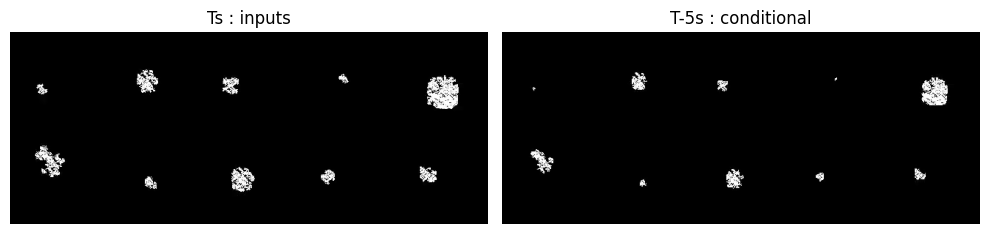

In [52]:
t_s, t_minus_5 = sample_n(test_loader, 10)
t_s_norm = (t_s + 1) / 2
t_minus_5_norm = (t_minus_5 + 1) / 2

grid1 = make_grid(t_s_norm, nrow=5)
grid_img1 = torchvision.transforms.ToPILImage()(grid1)
grid2 = make_grid(t_minus_5_norm, nrow=5)
grid_img2 = torchvision.transforms.ToPILImage()(grid2)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(grid1.permute(1, 2, 0))
axes[0].set_title('Ts : inputs')
axes[0].axis('off')

axes[1].imshow(grid2.permute(1, 2, 0))
axes[1].set_title('T-5s : conditional')
axes[1].axis('off')

plt.tight_layout()



In [53]:
def infer_conditional_fixed(conditional_imgs, save_final=False):
    model = Unet(model_config).to(device)
    model.load_state_dict(torch.load(MODEL_PATH))
    
    model.eval()
    
    scheduler = LinearNoiseScheduler(num_timesteps=diffusion_config["num_timesteps"],
                                     beta_start=diffusion_config["beta_start"],
                                     beta_end=diffusion_config["beta_end"],
                                     device=device)
    
    # _, conditional_imgs = sample_n(test_loader, NUM_SAMPLES)
    save_conditional_grid(conditional_imgs, nrows=2)
    
    with torch.no_grad():
        generated_output = sample_conditional(model, scheduler, conditional_imgs, grid_rows=2, sample_size=10, save_final=save_final)  
    
    return generated_output

In [54]:
outputs = infer_conditional_fixed(t_minus_5, save_final=True)

999it [00:34, 29.04it/s]


##### Structural Similarity Index 

In [55]:
def batch_ssim_loss(outputs, targets):
    """
    Calculate SSIM loss for a batch of output and target images.
    
    Args:
    - outputs (tensor): Batch of output images (B, C, H, W)
    - targets (tensor): Batch of target images (B, C, H, W)
    
    Returns:
    - ssim_losses (list): List of SSIM loss values for the batch
    """
    ssim_losses = []
    to_pil = torchvision.transforms.ToPILImage()

    for output, target in zip(outputs, targets):
        output_np = np.array(to_pil(output))
        target_np = np.array(to_pil(target))
        ssim_value = ssim(output_np, target_np, multichannel=True)
        ssim_loss = 1 - ssim_value
        ssim_losses.append(ssim_loss)
    
    return ssim_losses

def post_process(image_tensor):
    # Convert to PIL image
    to_pil = torchvision.transforms.ToPILImage()
    image_pil = to_pil(image_tensor)
    
    # Convert to grayscale
    grayscale_pil = torchvision.transforms.Grayscale()(image_pil)
    
    # Apply thresholding to convert to binary image
    binary_pil = grayscale_pil.point(lambda x: 0 if x < 128 else 255, '1')
    
    return binary_pil

Average SSIM Loss between output and input images: 0.7291223965258793
Average SSIM Loss between output and conditional images: 0.7260866779929691


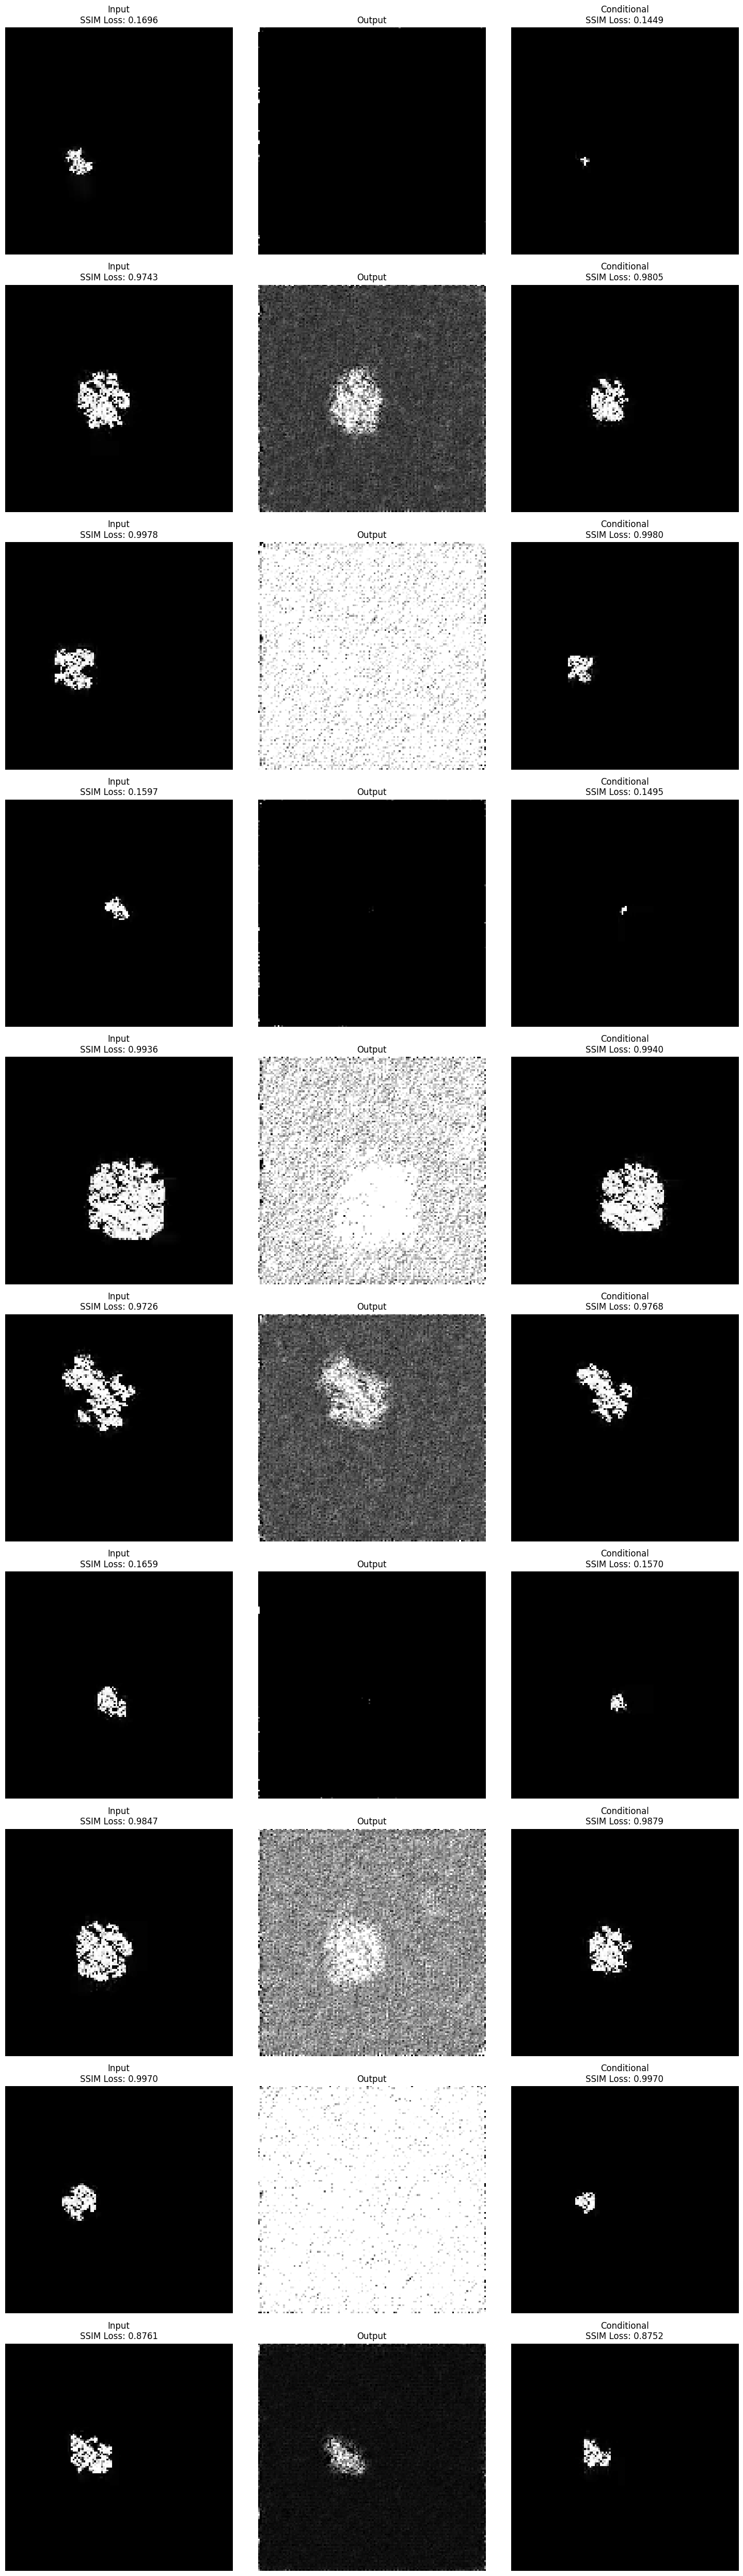

In [56]:
# Example tensor images (10 images in batch)
batch_size = 10

# Calculate SSIM loss values for the entire batch
ssim_losses_inputs = batch_ssim_loss(outputs, t_s)
ssim_losses_conditionals = batch_ssim_loss(outputs, t_minus_5)

print(f"Average SSIM Loss between output and input images: {np.array(ssim_losses_inputs).mean()}")
print(f"Average SSIM Loss between output and conditional images: {np.array(ssim_losses_conditionals).mean()}")


# Create a grid plot
fig, axes = plt.subplots(batch_size, 3, figsize=(15, 5 * batch_size))

to_pil = torchvision.transforms.ToPILImage()

for i in range(batch_size):
    # Convert tensors to PIL images for plotting
    input_img = to_pil(t_s[i])
    
    # output_img = to_pil(outputs[i])
    output_img = to_pil(outputs[i])
    
    cond_img = to_pil(t_minus_5[i])
    
    # Plot input image
    axes[i, 0].imshow(input_img, cmap='gray')
    axes[i, 0].set_title(f'Input\nSSIM Loss: {ssim_losses_inputs[i]:.4f}')
    axes[i, 0].axis('off')

    # Plot output image
    axes[i, 1].imshow(output_img, cmap='gray')
    axes[i, 1].set_title(f'Output')
    axes[i, 1].axis('off')

    # Plot conditional image
    axes[i, 2].imshow(cond_img, cmap='gray')
    axes[i, 2].set_title(f'Conditional\nSSIM Loss: {ssim_losses_conditionals[i]:.4f}')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

Average SSIM Loss between output and input images: 0.5025211342979743
Average SSIM Loss between output and conditional images: 0.4891843206851834


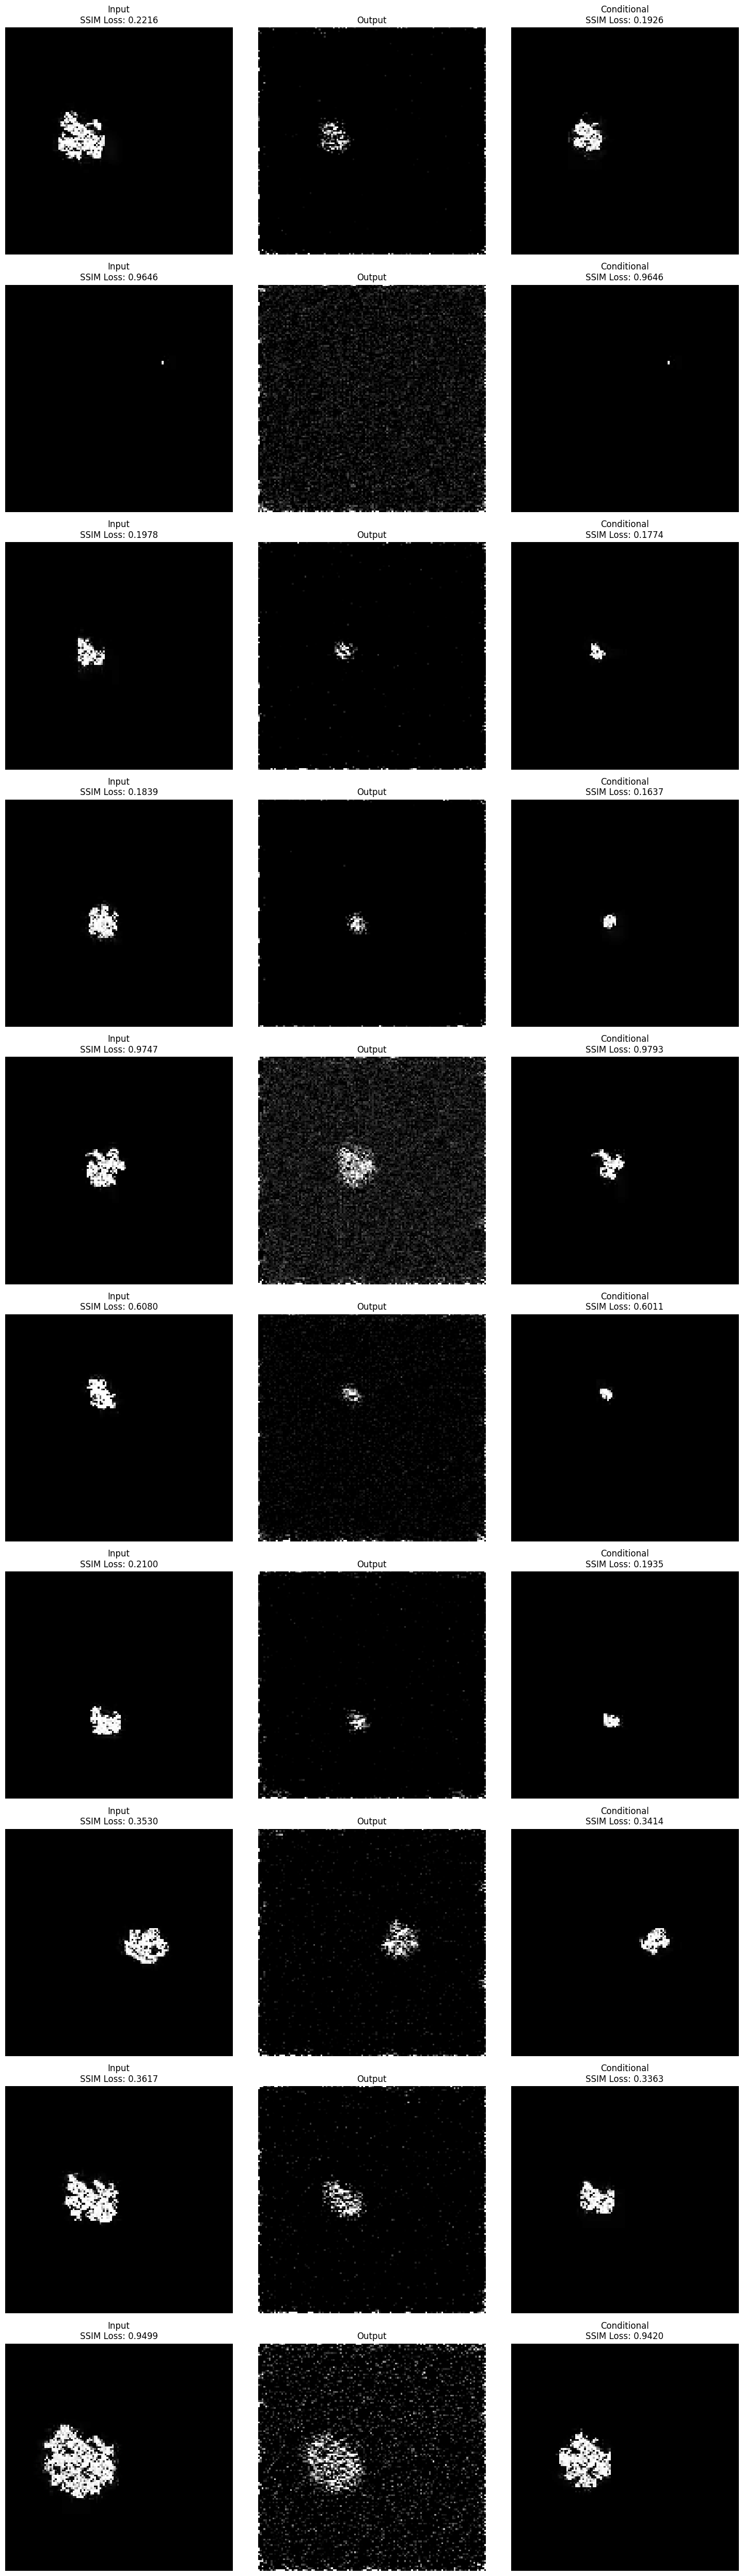

In [15]:
# Example tensor images (10 images in batch)
batch_size = 10

# Calculate SSIM loss values for the entire batch
ssim_losses_inputs = batch_ssim_loss(outputs, t_s)
ssim_losses_conditionals = batch_ssim_loss(outputs, t_minus_5)

print(f"Average SSIM Loss between output and input images: {np.array(ssim_losses_inputs).mean()}")
print(f"Average SSIM Loss between output and conditional images: {np.array(ssim_losses_conditionals).mean()}")


# Create a grid plot
fig, axes = plt.subplots(batch_size, 3, figsize=(15, 5 * batch_size))

to_pil = torchvision.transforms.ToPILImage()

for i in range(batch_size):
    # Convert tensors to PIL images for plotting
    input_img = to_pil(t_s[i])
    
    # output_img = to_pil(outputs[i])
    output_img = to_pil(outputs[i])
    
    cond_img = to_pil(t_minus_5[i])
    
    # Plot input image
    axes[i, 0].imshow(input_img, cmap='gray')
    axes[i, 0].set_title(f'Input\nSSIM Loss: {ssim_losses_inputs[i]:.4f}')
    axes[i, 0].axis('off')

    # Plot output image
    axes[i, 1].imshow(output_img, cmap='gray')
    axes[i, 1].set_title(f'Output')
    axes[i, 1].axis('off')

    # Plot conditional image
    axes[i, 2].imshow(cond_img, cmap='gray')
    axes[i, 2].set_title(f'Conditional\nSSIM Loss: {ssim_losses_conditionals[i]:.4f}')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

##### Mean Squared Error 

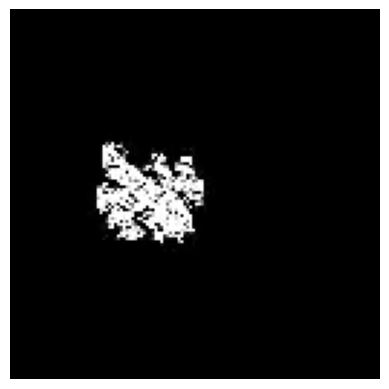

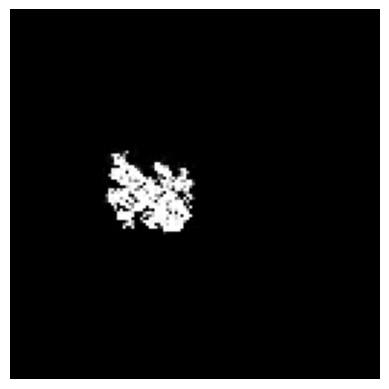

In [21]:
for img1, img2 in train_loader:
    plt.imshow(img1[0].permute(1, 2, 0), cmap="gray")
    plt.axis('off')
    plt.show()
    plt.imshow(img2[0].permute(1, 2, 0), cmap="gray")
    plt.axis('off')
    plt.show()
    break

(20, 128, 128)


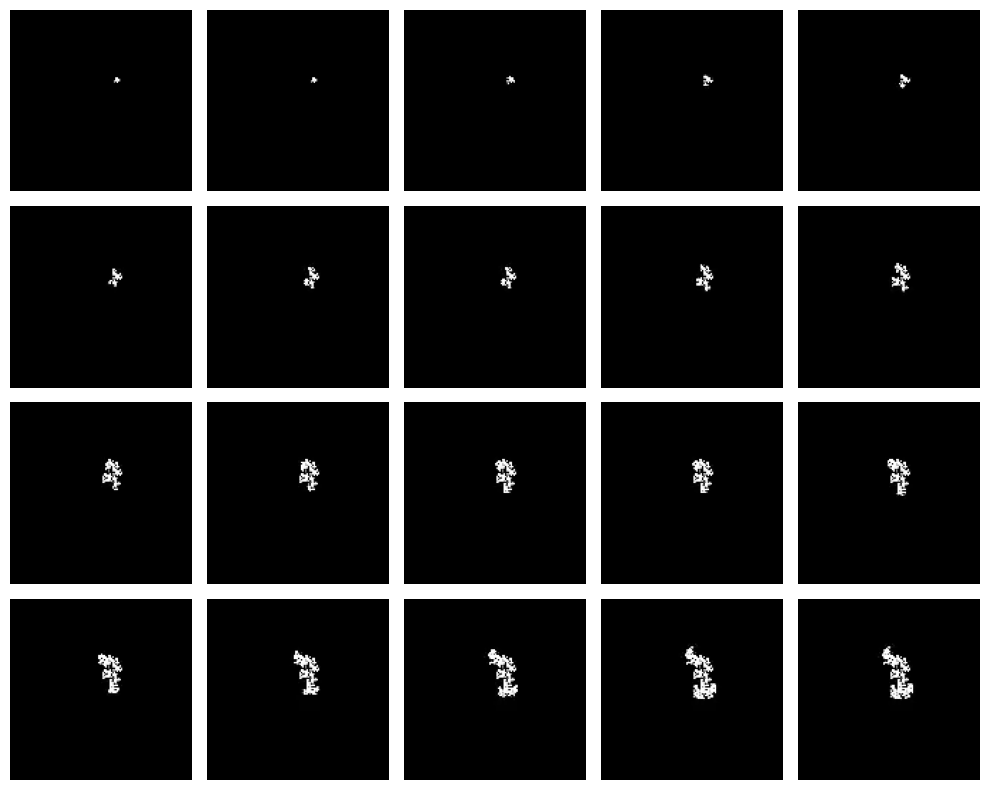

In [25]:
path = os.path.join(DATA_DIR, "bin_frames", "fire_Chimney_video_1.mpy")

with open(path, 'rb') as f:
    frames = pickle.load(f)
    frames = np.array(frames)
    
print(frames.shape)

def create_image_grid(images, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i], cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
create_image_grid(frames, 4, 5)